In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load the data
train = pd.read_csv("kaggle/input/playground-series-s3e11/train.csv")
test = pd.read_csv("kaggle/input/playground-series-s3e11/test.csv")
sample_submission = pd.read_csv('kaggle/input/playground-series-s3e11/sample_submission.csv')

In [3]:
# Train Info
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360336 entries, 0 to 360335
Data columns (total 17 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   id                          360336 non-null  int64  
 1   store_sales(in millions)    360336 non-null  float64
 2   unit_sales(in millions)     360336 non-null  float64
 3   total_children              360336 non-null  float64
 4   num_children_at_home        360336 non-null  float64
 5   avg_cars_at home(approx).1  360336 non-null  float64
 6   gross_weight                360336 non-null  float64
 7   recyclable_package          360336 non-null  float64
 8   low_fat                     360336 non-null  float64
 9   units_per_case              360336 non-null  float64
 10  store_sqft                  360336 non-null  float64
 11  coffee_bar                  360336 non-null  float64
 12  video_store                 360336 non-null  float64
 13  salad_bar     

In [4]:
# Test Info
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240224 entries, 0 to 240223
Data columns (total 16 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   id                          240224 non-null  int64  
 1   store_sales(in millions)    240224 non-null  float64
 2   unit_sales(in millions)     240224 non-null  float64
 3   total_children              240224 non-null  float64
 4   num_children_at_home        240224 non-null  float64
 5   avg_cars_at home(approx).1  240224 non-null  float64
 6   gross_weight                240224 non-null  float64
 7   recyclable_package          240224 non-null  float64
 8   low_fat                     240224 non-null  float64
 9   units_per_case              240224 non-null  float64
 10  store_sqft                  240224 non-null  float64
 11  coffee_bar                  240224 non-null  float64
 12  video_store                 240224 non-null  float64
 13  salad_bar     

In [5]:
def summary(df):
    print(f"\n📊 Data Shape: {df.shape}\n")
    
    summ = pd.DataFrame(df.dtypes, columns=["Data Type"])
    summ["# Missing"] = df.isnull().sum()
    summ["% Missing"] = (df.isnull().sum() / len(df)) * 100
    summ["# Unique"] = df.nunique()
    
    desc = df.describe(include="all").transpose()
    summ["Min"] = desc.get("min")
    summ["Max"] = desc.get("max")
    
    # Add first three values if enough rows exist
    for i in range(3):
        if len(df) > i:
            summ[f"Value {i+1}"] = df.iloc[i]
    
    # Formatting for better readability
    return summ.style.format({
        "% Missing": "{:.2f}%",
        "Min": "{:.2f}",
        "Max": "{:.2f}"
    }).bar(subset=["% Missing"], color="lightcoral")  # Highlight missing data

In [6]:
# Display summary of the training data
summary(train)


📊 Data Shape: (360336, 17)



c:\Users\cleme\OneDrive - Nanyang Technological University\Documents\GitHub\sc4000-kaggle-ml-project\venv\Lib\site-packages\pandas\io\formats\style.py:4040: RuntimeWarning: invalid value encountered in scalar divide
  end = (x - left) / (right - left)


,Data Type,# Missing,% Missing,# Unique,Min,Max,Value 1,Value 2,Value 3
id,int64,0,0.00%,360336,0.00,360335.00,0.000000,1.000000,2.000000
store_sales(in millions),float64,0,0.00%,1044,0.51,22.92,8.610000,5.000000,14.080000
unit_sales(in millions),float64,0,0.00%,6,1.00,6.00,3.000000,2.000000,4.000000
total_children,float64,0,0.00%,6,0.00,5.00,2.000000,4.000000,0.000000
num_children_at_home,float64,0,0.00%,6,0.00,5.00,2.000000,0.000000,0.000000
avg_cars_at home(approx).1,float64,0,0.00%,5,0.00,4.00,2.000000,3.000000,3.000000
gross_weight,float64,0,0.00%,384,6.00,21.90,10.300000,6.660000,21.300000
recyclable_package,float64,0,0.00%,2,0.00,1.00,1.000000,1.000000,1.000000
low_fat,float64,0,0.00%,2,0.00,1.00,0.000000,0.000000,0.000000
units_per_case,float64,0,0.00%,36,1.00,36.00,32.000000,1.000000,26.000000


In [7]:
# Display summary of the test data
summary(test)


📊 Data Shape: (240224, 16)



c:\Users\cleme\OneDrive - Nanyang Technological University\Documents\GitHub\sc4000-kaggle-ml-project\venv\Lib\site-packages\pandas\io\formats\style.py:4040: RuntimeWarning: invalid value encountered in scalar divide
  end = (x - left) / (right - left)


,Data Type,# Missing,% Missing,# Unique,Min,Max,Value 1,Value 2,Value 3
id,int64,0,0.00%,240224,360336.00,600559.00,360336.000000,360337.000000,360338.000000
store_sales(in millions),float64,0,0.00%,1035,0.51,22.92,7.240000,6.900000,8.340000
unit_sales(in millions),float64,0,0.00%,6,1.00,6.00,4.000000,2.000000,3.000000
total_children,float64,0,0.00%,6,0.00,5.00,1.000000,2.000000,0.000000
num_children_at_home,float64,0,0.00%,6,0.00,5.00,0.000000,2.000000,0.000000
avg_cars_at home(approx).1,float64,0,0.00%,5,0.00,4.00,2.000000,3.000000,3.000000
gross_weight,float64,0,0.00%,380,6.00,21.90,10.800000,8.510000,8.770000
recyclable_package,float64,0,0.00%,2,0.00,1.00,0.000000,1.000000,0.000000
low_fat,float64,0,0.00%,2,0.00,1.00,1.000000,0.000000,1.000000
units_per_case,float64,0,0.00%,36,1.00,36.00,7.000000,4.000000,14.000000


In [8]:
# Display summary of the sample submission
summary(sample_submission)


📊 Data Shape: (240224, 2)



c:\Users\cleme\OneDrive - Nanyang Technological University\Documents\GitHub\sc4000-kaggle-ml-project\venv\Lib\site-packages\pandas\io\formats\style.py:4040: RuntimeWarning: invalid value encountered in scalar divide
  end = (x - left) / (right - left)


,Data Type,# Missing,% Missing,# Unique,Min,Max,Value 1,Value 2,Value 3
id,int64,0,0.00%,240224,360336.00,600559.00,360336.000000,360337.000000,360338.000000
cost,float64,0,0.00%,1,99.61,99.61,99.615000,99.615000,99.615000


In [9]:
# Features
features = ['store_sales(in millions)', 'unit_sales(in millions)', 'total_children',
            'num_children_at_home', 'avg_cars_at home(approx).1',
            'gross_weight', 'recyclable_package', 'low_fat', 'units_per_case', 'store_sqft', 'coffee_bar',
            'video_store', 'salad_bar', 'prepared_food', 'florist']

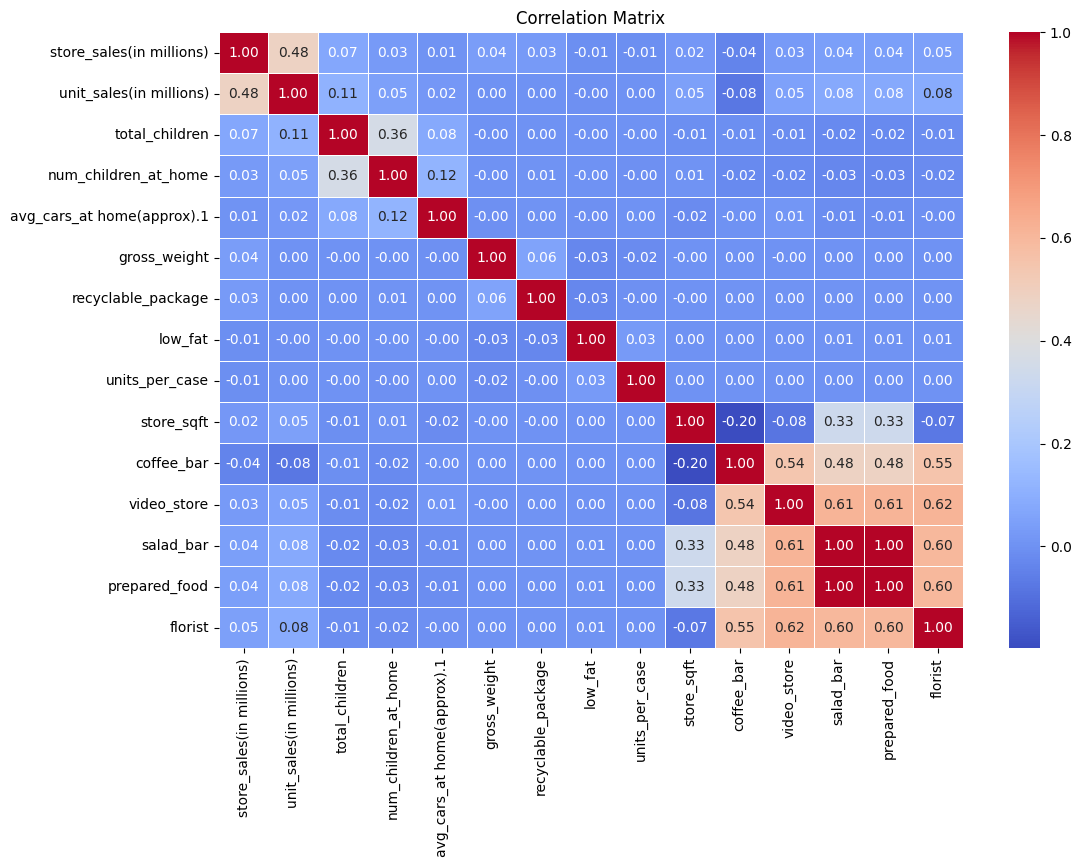

                       Feature          VIF
0                        const    72.189041
1     store_sales(in millions)     1.306200
2      unit_sales(in millions)     1.349211
3               total_children     1.164054
4         num_children_at_home     1.159692
5   avg_cars_at home(approx).1     1.016236
6                 gross_weight     1.006505
7           recyclable_package     1.005367
8                      low_fat     1.002892
9               units_per_case     1.001342
10                  store_sqft     1.544479
11                  coffee_bar     1.820009
12                 video_store     2.124960
13                   salad_bar  3106.890212
14               prepared_food  3106.945240
15                     florist     2.070160
Features with high VIF: ['const', 'salad_bar', 'prepared_food']
Highly correlated features: {'prepared_food'}
Features to drop: {'salad_bar', 'prepared_food', 'const'}
Selected features: ['store_sales(in millions)', 'unit_sales(in millions)', 'total_ch

In [10]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import seaborn as sns

# Step 1: Calculate correlation matrix
corr_matrix = train[features].corr()

# Plot correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

# Step 2: Calculate VIF for each feature
# Add constant to the data (for VIF calculation)
X = train[features]
X_with_const = add_constant(X)  # Adds a constant column for VIF calculation

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X_with_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_with_const.values, i) for i in range(X_with_const.shape[1])]

# Display VIF data
print(vif_data)

# Step 3: Feature selection based on VIF and correlation
# Thresholds for VIF and correlation
VIF_THRESHOLD = 10  # Features with VIF above 10 are considered to have high multicollinearity
CORR_THRESHOLD = 0.8  # Correlation greater than 0.8 means features are highly correlated

# Remove features with high VIF
high_vif_features = vif_data[vif_data['VIF'] > VIF_THRESHOLD]['Feature'].tolist()
print(f"Features with high VIF: {high_vif_features}")

# Remove features with high correlation
correlated_features = []
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > CORR_THRESHOLD:
            colname = corr_matrix.columns[i]
            correlated_features.append(colname)

print(f"Highly correlated features: {set(correlated_features)}")

# Combine features to drop: high VIF and high correlation
features_to_drop = set(high_vif_features + correlated_features)
print(f"Features to drop: {features_to_drop}")

# Final feature set after dropping highly correlated and high-VIF features
final_features = [f for f in features if f not in features_to_drop]
print(f"Selected features: {final_features}")

# Now, we can continue with feature selection
X_train_selected = train[final_features]

In [11]:
# Cleaning data by removing outliers
# Outlier detection using IQR method
def remove_outliers(df, features):
    # Calculate the IQR for each feature
    for feature in features:
        Q1 = df[feature].quantile(0.25)
        Q3 = df[feature].quantile(0.75)
        IQR = Q3 - Q1
        
        # Define bounds for detecting outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Remove outliers
        df = df[(df[feature] >= lower_bound) & (df[feature] <= upper_bound)]
    return df

In [12]:
# Remove outliers
train_cleaned = remove_outliers(train.copy(), features)

In [13]:
train.shape, train_cleaned.shape

((360336, 17), (312253, 17))

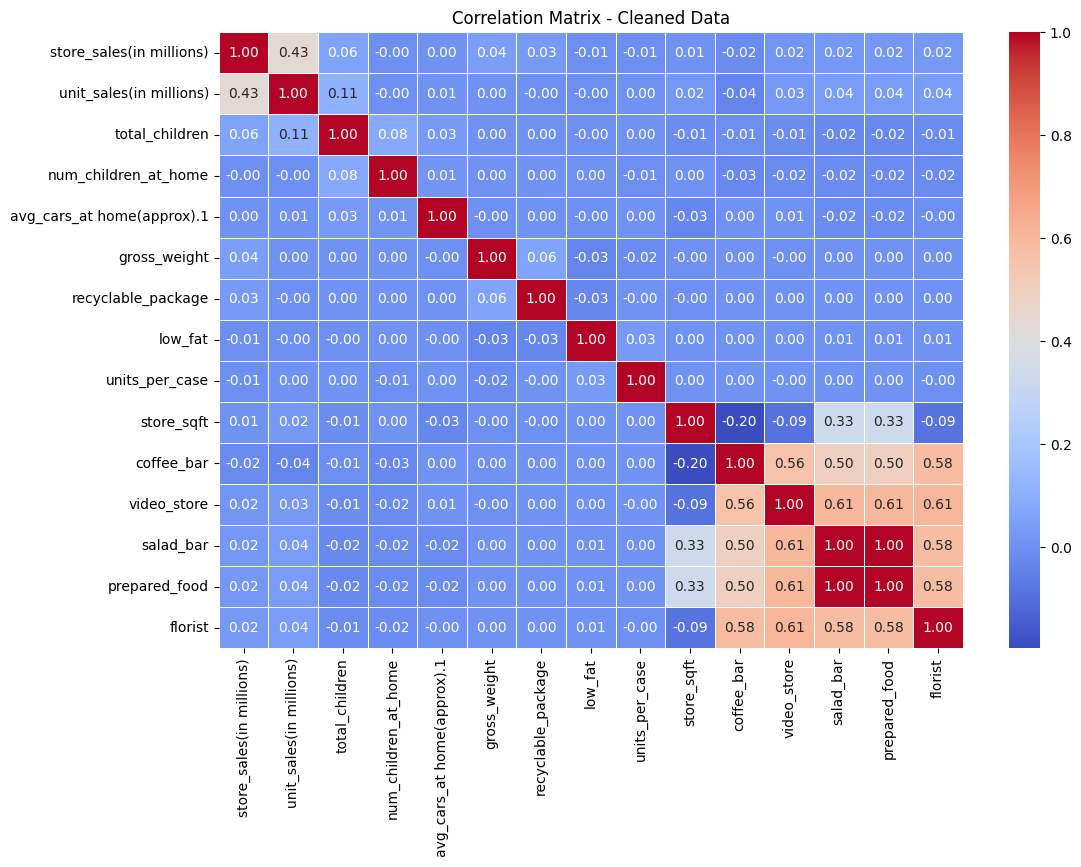

                       Feature          VIF
0                        const    73.778677
1     store_sales(in millions)     1.233791
2      unit_sales(in millions)     1.247764
3               total_children     1.020719
4         num_children_at_home     1.007905
5   avg_cars_at home(approx).1     1.002227
6                 gross_weight     1.007168
7           recyclable_package     1.005535
8                      low_fat     1.002801
9               units_per_case     1.001318
10                  store_sqft     1.552024
11                  coffee_bar     1.876625
12                 video_store     2.114832
13                   salad_bar  3544.474348
14               prepared_food  3544.337460
15                     florist     2.046721
Features with high VIF: ['const', 'salad_bar', 'prepared_food']
Highly correlated features: {'prepared_food'}
Features to drop: {'salad_bar', 'prepared_food', 'const'}
Selected features: ['store_sales(in millions)', 'unit_sales(in millions)', 'total_ch

In [14]:
# Dataset after removing outliers
# Step 1: Calculate correlation matrix
corr_matrix = train_cleaned[features].corr()

# Plot correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix - Cleaned Data')
plt.show()

# Step 2: Calculate VIF for each feature
# Add constant to the data (for VIF calculation)
X = train_cleaned[features]
X_with_const = add_constant(X)  # Adds a constant column for VIF calculation

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X_with_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_with_const.values, i) for i in range(X_with_const.shape[1])]

# Display VIF data
print(vif_data)

# Step 3: Feature selection based on VIF and correlation
# Thresholds for VIF and correlation
VIF_THRESHOLD = 10  # Features with VIF above 10 are considered to have high multicollinearity
CORR_THRESHOLD = 0.8  # Correlation greater than 0.8 means features are highly correlated

# Remove features with high VIF
high_vif_features = vif_data[vif_data['VIF'] > VIF_THRESHOLD]['Feature'].tolist()
print(f"Features with high VIF: {high_vif_features}")

# Remove features with high correlation
correlated_features = []
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > CORR_THRESHOLD:
            colname = corr_matrix.columns[i]
            correlated_features.append(colname)

print(f"Highly correlated features: {set(correlated_features)}")

# Combine features to drop: high VIF and high correlation
features_to_drop = set(high_vif_features + correlated_features)
print(f"Features to drop: {features_to_drop}")

# Final feature set after dropping highly correlated and high-VIF features
final_features = [f for f in features if f not in features_to_drop]
print(f"Selected features: {final_features}")

# Now, we can continue with feature selection
X_train_selected = train_cleaned[final_features]

In [16]:
# Export the cleaned data as CSV
train_cleaned.to_csv('kaggle/output/train_without_outliers.csv', index=False)